# Electro Pi Scholarship
## Week 2: Supervised Learning (Classics)
**Requirements**: Building a large notebook to deal with the problem and compare between all models you have learnt so far after tuning them  with your favorite hyper tuning parameters technique.  


### Problem 2: Predict Employee Attrition and Performance.

**About Dataset**  
Uncover the factors that lead to employee attrition and explore important questions such as 'Show me a breakdown of distance from home by job role and attrition' or 'Compare average monthly income by education and attrition'. This is a fictional data set created by **IBM data scientists**, Dataset link is [here](https://www.kaggle.com/datasets/pavansubhasht/ibm-hr-analytics-attrition-dataset?select=WA_Fn-UseC_-HR-Employee-Attrition.csv).

**Note**: These columns contain integers, the integers represented categories as mentioned below:
1. `Education`: {1 'Below College', 2 'College', 3 'Bachelor', 4 'Master', 5 'Doctor'}
2. `EnvironmentSatisfaction`: {1 'Low', 2 'Medium', 3 'High', 4 'Very High'}  
3. `JobInvolvement`: {1 'Low', 2 'Medium', 3 'High', 4 'Very High'}
4. `JobSatisfaction`: {1 'Low', 2 'Medium', 3 'High', 4 'Very High'}
5. `PerformanceRating`: {1 'Low', 2 'Good', 3 'Excellent', 4 'Outstanding'}
6. `RelationshipSatisfaction`: {1 'Low', 2 'Medium', 3 'High', 4 'Very High'}
7. `WorkLifeBalance`: {1 'Bad', 2 'Good', 3 'Better', 4 'Best'}

# 01 Importing Modules

We will first download `catboost`, and `scikit-optimize` packages.

In [1]:
# '--upgrade --quiet --exists-action i' is for remove warning messages which take a lot of spcace
! pip install catboost --upgrade --quiet --exists-action i
! pip install scikit-optimize --upgrade --quiet --exists-action i

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
redshift-connector 2.0.900 requires pytz<2021.9,>=2020.1, but you have pytz 2022.2 which is incompatible.
awscli 1.19.53 requires PyYAML<5.5,>=3.10, but you have pyyaml 6.0 which is incompatible.
pythonwhat 2.23.1 requires dill~=0.2.7.1, but you have dill 0.3.3 which is incompatible.
pythonwhat 2.23.1 requires jinja2~=2.10, but you have jinja2 3.0.1 which is incompatible.
--- Logging error ---
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/pip/_internal/utils/logging.py", line 177, in emit
    self.console.print(renderable, overflow="ignore", crop=False, style=style)
  File "/usr/local/lib/python3.8/dist-packages/pip/_vendor/rich/console.py", line 1673, in print
    extend(render(renderable, render_options))
  File "/usr/local/lib/python3.8/dist-packages/pip/_vendor/rich/console.

In [2]:
# load modules
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pickle

# Hyper-parameters related packages
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

# support packages 
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# Classical Classifiers
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

# Ensamble Learning
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Show all columns' content
pd.set_option('display.max_colwidth', None)

# 02 Loading and Reviewing Datasets 

In [3]:
# load WA_Fn-UseC_-HR-Employee-Attrition to df
df = pd.read_csv('IBM HR Analytics Employee Attrition & Performance/WA_Fn-UseC_-HR-Employee-Attrition.csv')

# Replace all numbers in the categorical columns with its true values
cat_cols = {
    'Education': {1: 'Below College', 2: 'College', 3: 'Bachelor', 4: 'Master', 5: 'Doctor'},
    'EnvironmentSatisfaction': {1: 'Low', 2: 'Medium', 3: 'High', 4: 'Very High'},  
    'JobInvolvement': {1: 'Low', 2: 'Medium', 3: 'High', 4: 'Very High'},
    'JobSatisfaction': {1: 'Low', 2: 'Medium', 3: 'High', 4: 'Very High'},
    'PerformanceRating': {1: 'Low', 2: 'Good', 3: 'Excellent', 4: 'Outstanding'},
    'RelationshipSatisfaction': {1: 'Low', 2: 'Medium', 3: 'High', 4: 'Very High'},
    'WorkLifeBalance': {1: 'Bad', 2: 'Good', 3: 'Better', 4: 'Best'}
}

for col in cat_cols.keys():
    df[col] = df[col].replace(cat_cols[col])

# see first rows, information, describtion of both numerical and non-numerical columns
display(df.head())
display(df.info())
display(df.describe().T) # We have too much columns, to see them all, we will transpose the table
display(df.describe(exclude='number'))

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,College,Life Sciences,1,1,...,Low,80,0,8,0,Bad,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,Below College,Life Sciences,1,2,...,Very High,80,1,10,3,Better,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,College,Other,1,4,...,Medium,80,0,7,3,Better,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,Master,Life Sciences,1,5,...,High,80,0,8,3,Better,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,Below College,Medical,1,7,...,Very High,80,1,6,3,Better,2,2,2,2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   object
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   object
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   object
 14  JobLevel                

None

,count,mean,std,min,25%,50%,75%,max
Age,1470.0,36.923810,9.135373,18.0,30.00,36.0,43.00,60.0
DailyRate,1470.0,802.485714,403.509100,102.0,465.00,802.0,1157.00,1499.0
DistanceFromHome,1470.0,9.192517,8.106864,1.0,2.00,7.0,14.00,29.0
EmployeeCount,1470.0,1.000000,0.000000,1.0,1.00,1.0,1.00,1.0
EmployeeNumber,1470.0,1024.865306,602.024335,1.0,491.25,1020.5,1555.75,2068.0
HourlyRate,1470.0,65.891156,20.329428,30.0,48.00,66.0,83.75,100.0
JobLevel,1470.0,2.063946,1.106940,1.0,1.00,2.0,3.00,5.0
MonthlyIncome,1470.0,6502.931293,4707.956783,1009.0,2911.00,4919.0,8379.00,19999.0
MonthlyRate,1470.0,14313.103401,7117.786044,2094.0,8047.00,14235.5,20461.50,26999.0
NumCompaniesWorked,1470.0,2.693197,2.498009,0.0,1.00,2.0,4.00,9.0


,Attrition,BusinessTravel,Department,Education,EducationField,EnvironmentSatisfaction,Gender,JobInvolvement,JobRole,JobSatisfaction,MaritalStatus,Over18,OverTime,PerformanceRating,RelationshipSatisfaction,WorkLifeBalance
count,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470
unique,2,3,3,5,6,4,2,4,9,4,3,1,2,2,4,4
top,No,Travel_Rarely,Research & Development,Bachelor,Life Sciences,High,Male,High,Sales Executive,Very High,Married,Y,No,Excellent,High,Better
freq,1233,1043,961,572,606,453,882,868,326,459,673,1470,1054,1244,459,893


**We can notice that:**
1. No missing values.
2. `EmployeeCount`, `StandardHours`, and `Over18` Columns have only one value so we will drop them.
3. Around `84%` of Employees are not Attrition.

In [4]:
# first lets check if there is duplicated columns
df.duplicated().sum()

0

No duplication ....

In [5]:
# Drop [EmployeeCount`, `StandardHours`, `Over18`] columns 
df.drop(['EmployeeCount', 'StandardHours', 'Over18'], axis=1, inplace=True)

# 03. EDA for Dataset

## 03.01 EDA for Numerical Columns

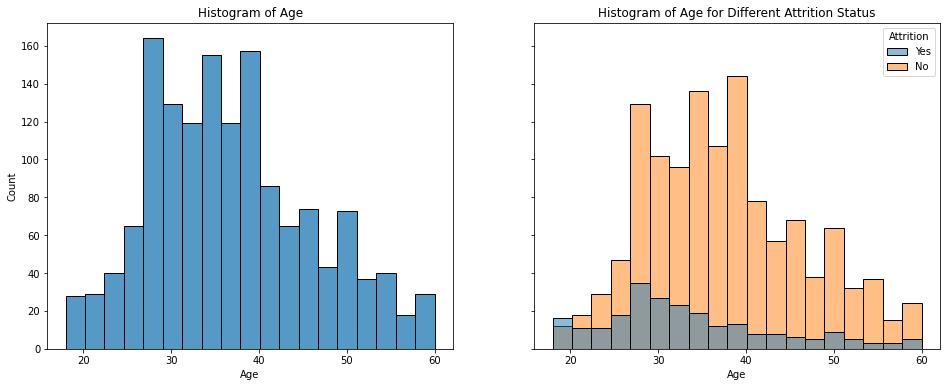

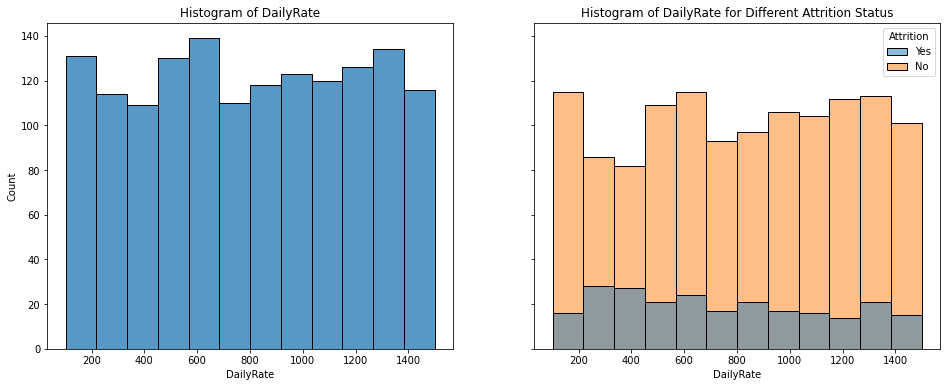

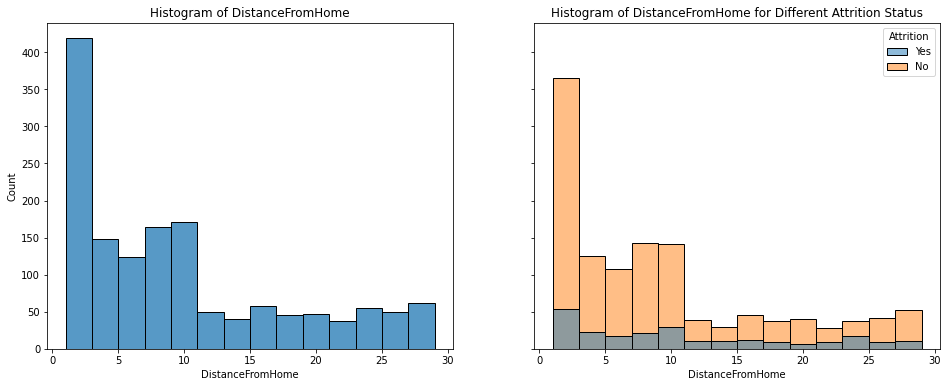

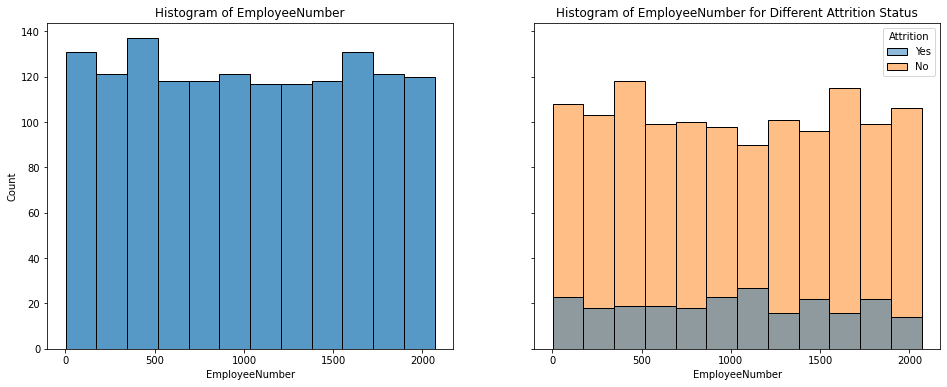

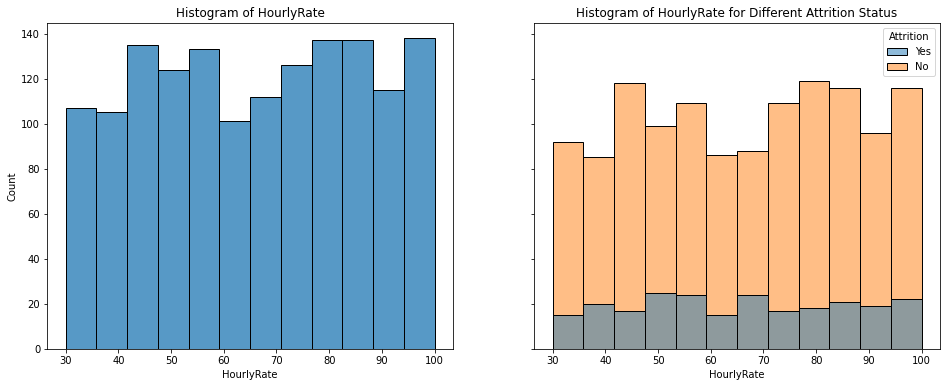

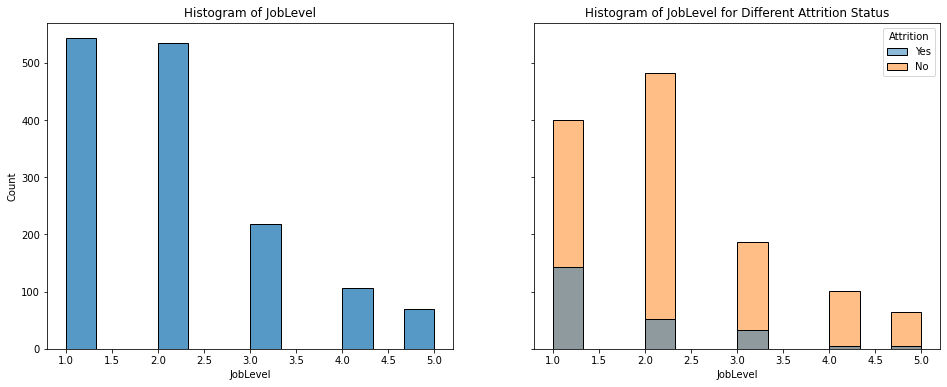

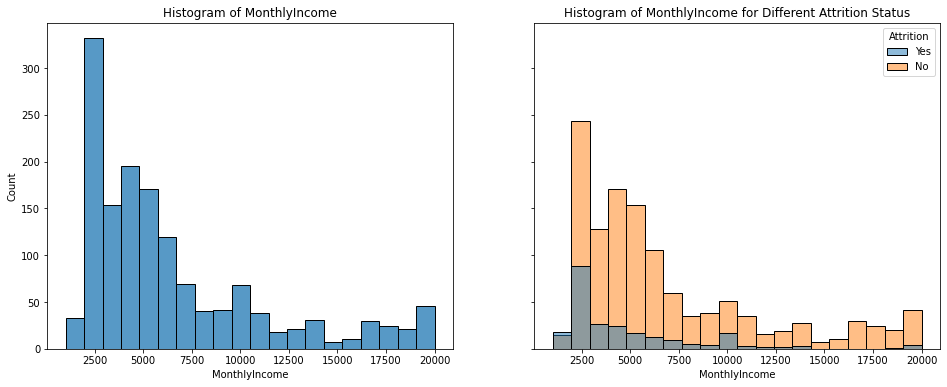

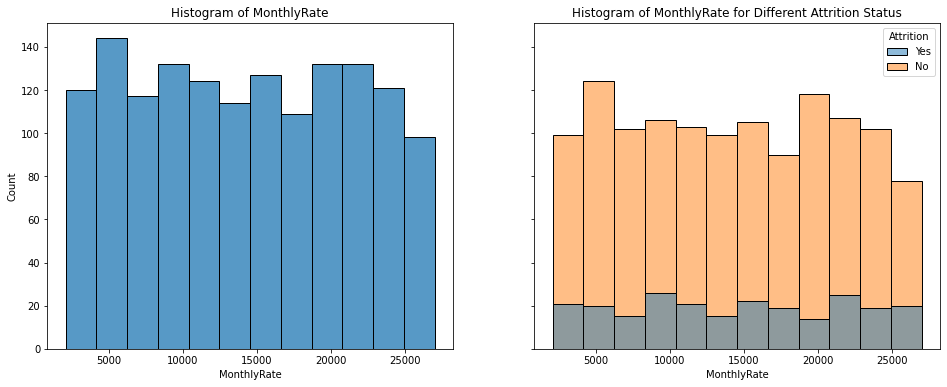

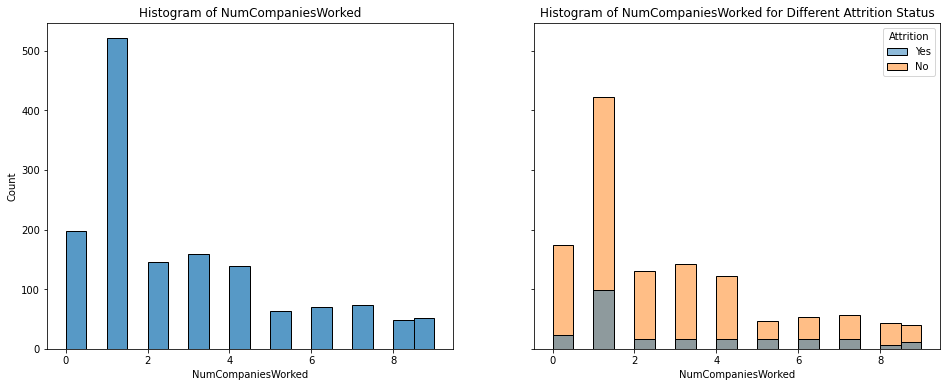

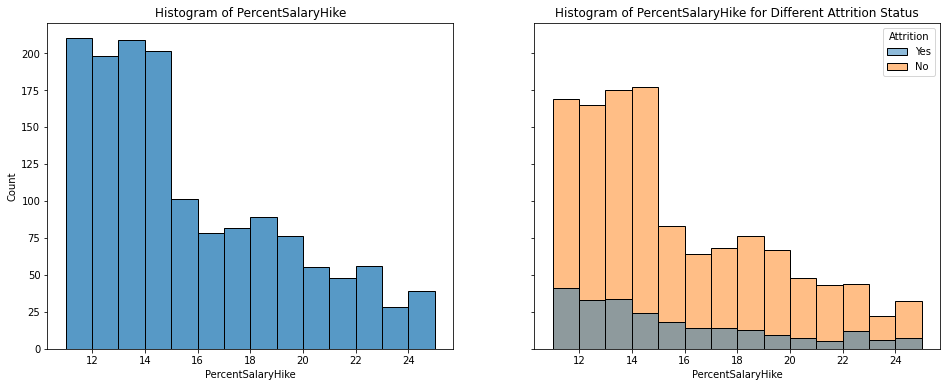

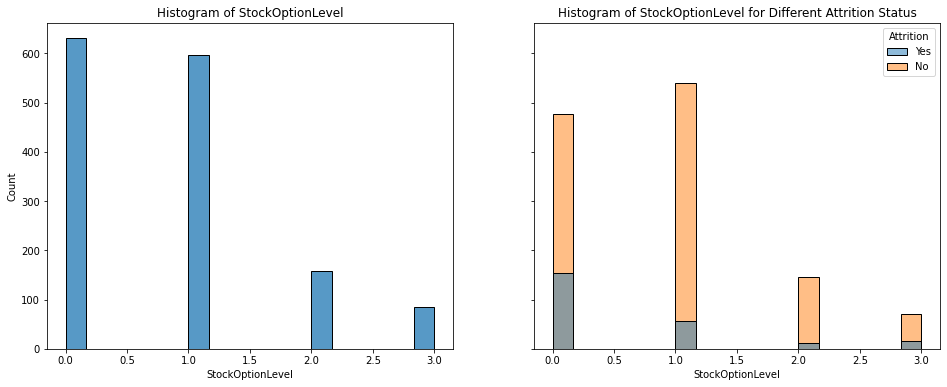

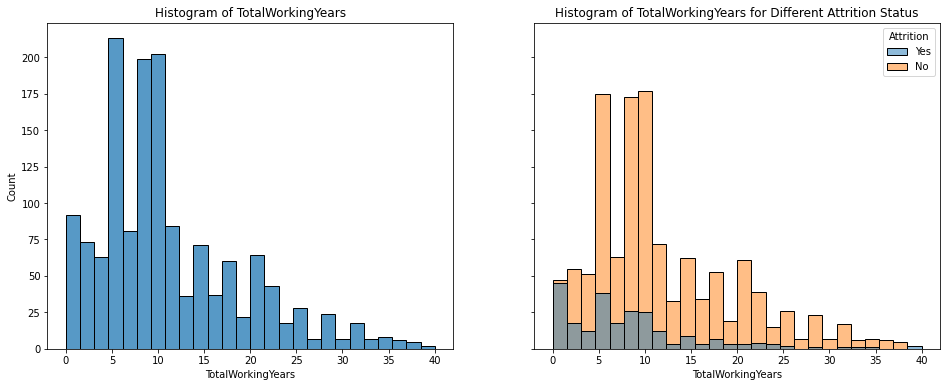

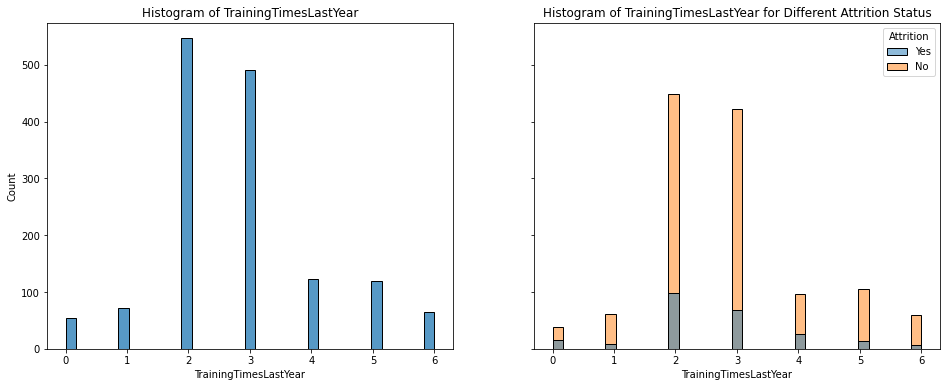

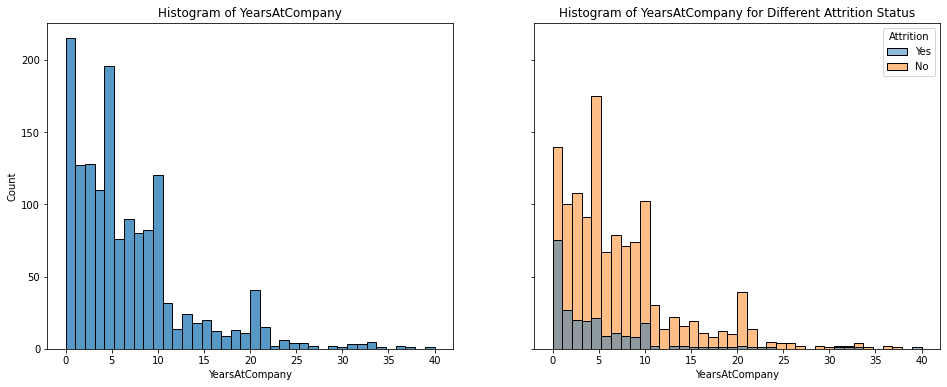

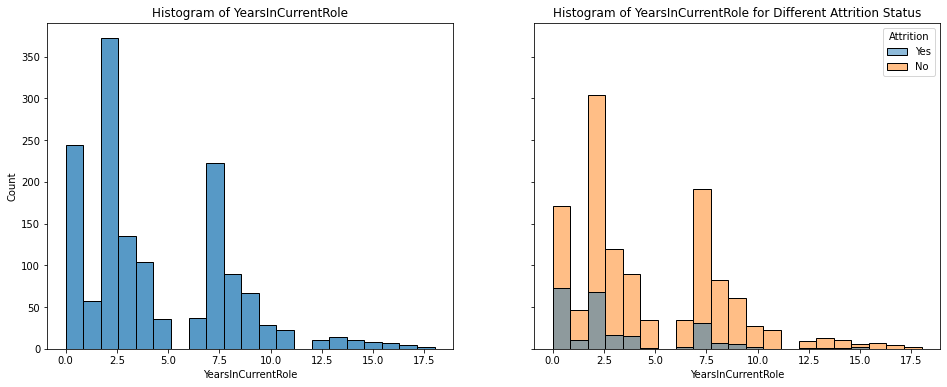

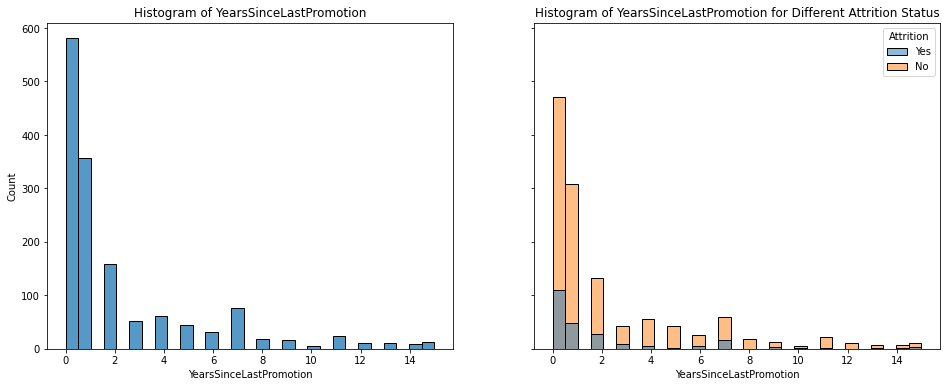

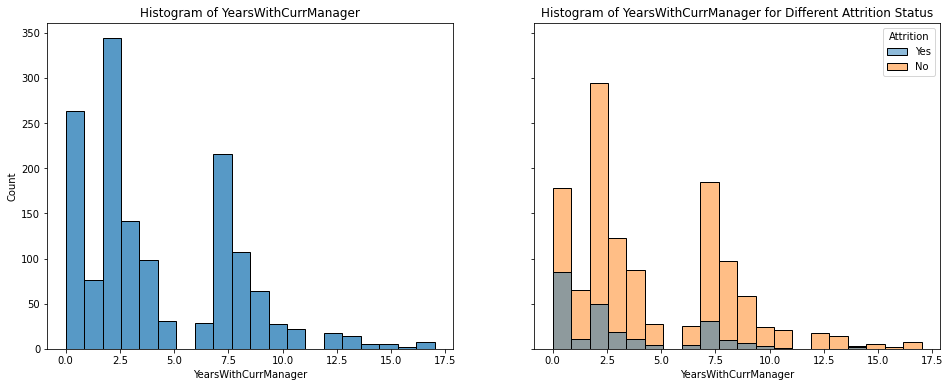

In [6]:
# loop over all numerical columns
for col in df.select_dtypes(include=np.number).columns:
    # make 2*1 plot
    fig, axes = plt.subplots(1, 2, sharey=True, figsize=(16, 6))
    # plot histogram in subplot 1
    sns.histplot(data = df, x=col, ax=axes[0]).set_title(
        'Histogram of '+ col)
    # plot histogram in subplot 2 with 'Churn' as legend
    sns.histplot(data = df, x=col, ax=axes[1], hue='Attrition', alpha=0.5).set_title(
        'Histogram of '+ col + ' for Different Attrition Status')

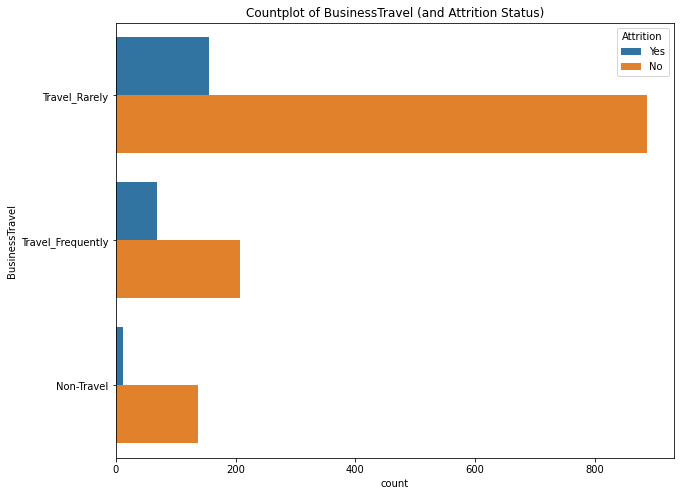

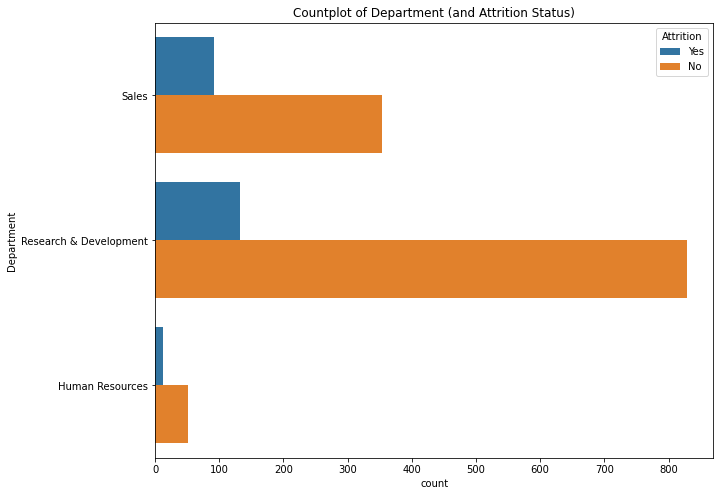

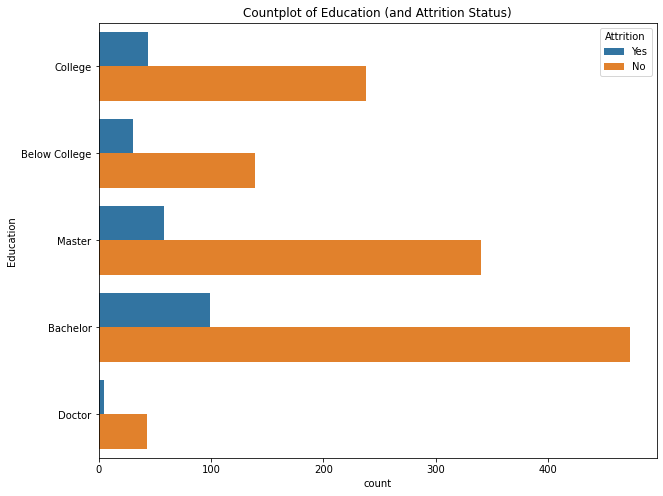

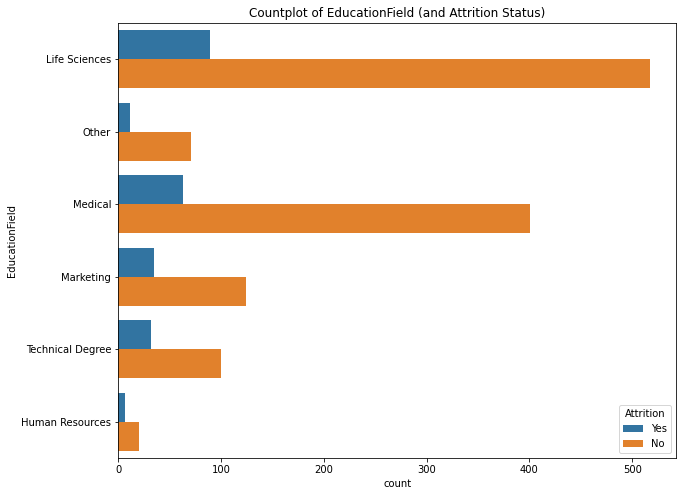

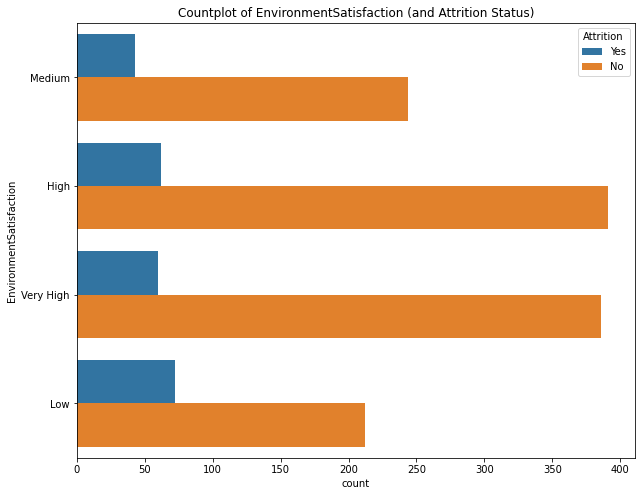

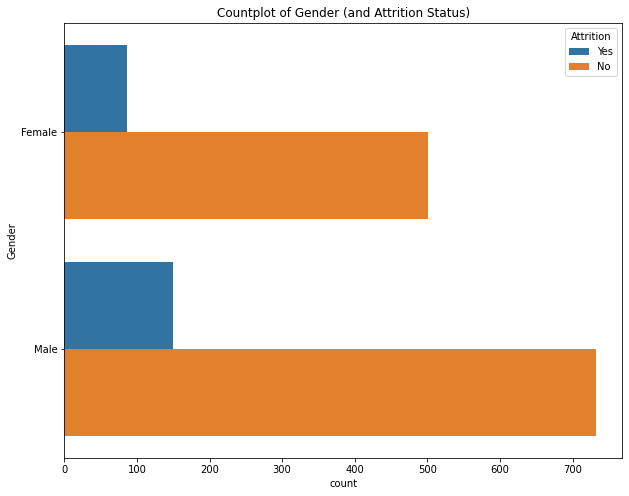

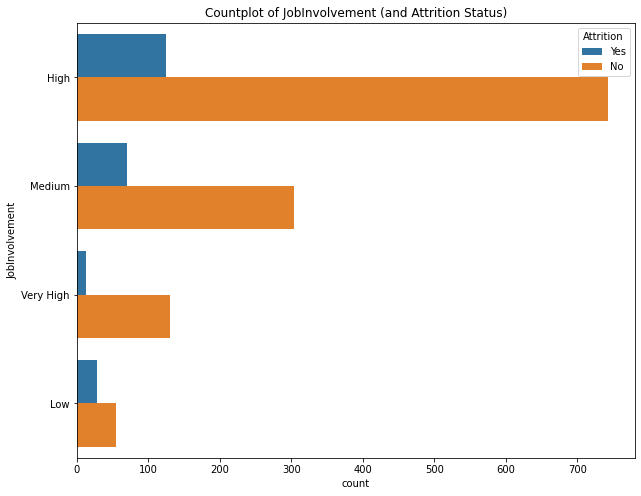

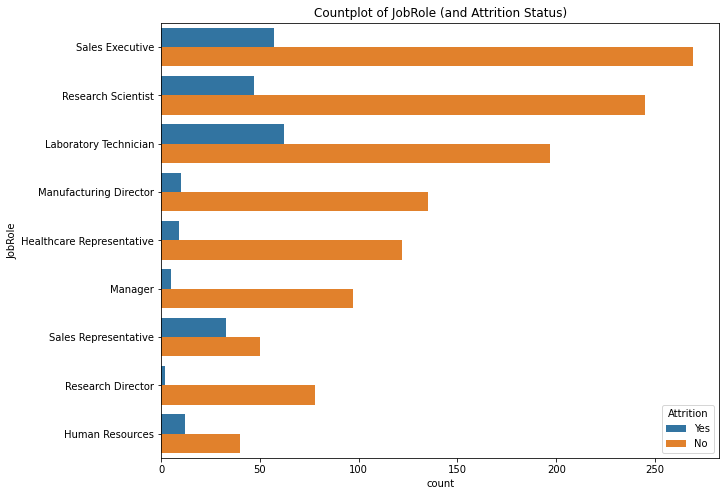

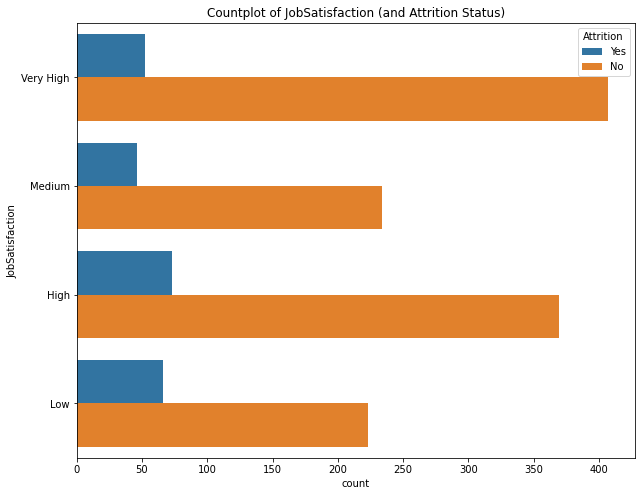

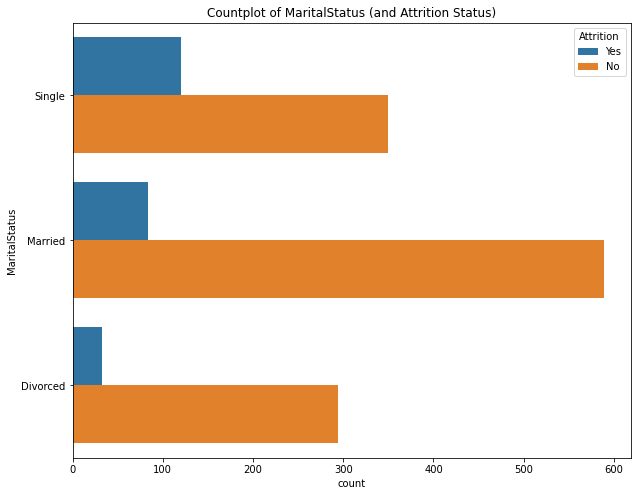

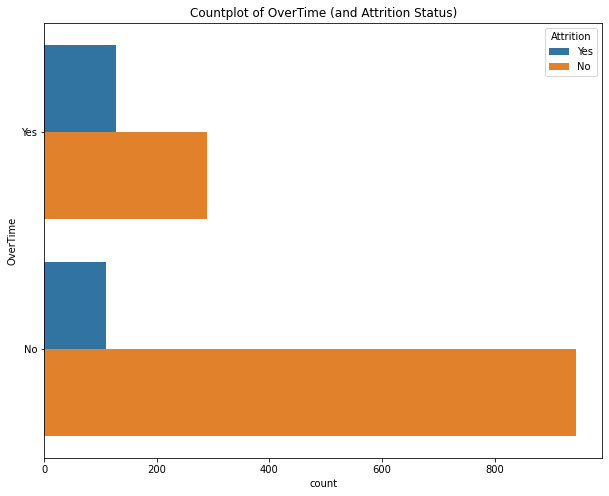

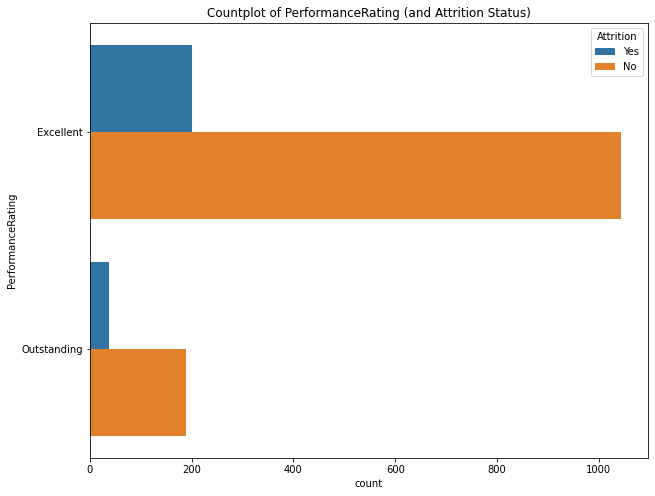

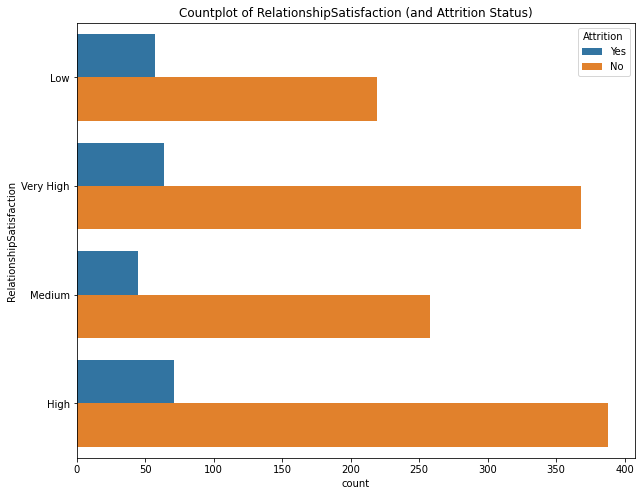

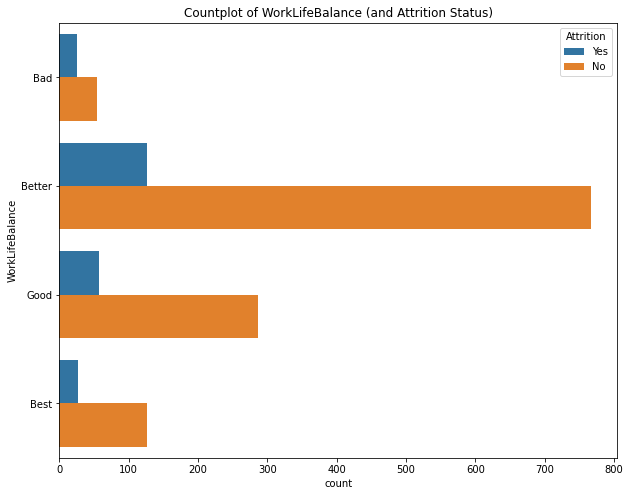

In [7]:
# loop over all non numerical columns
for col in df.select_dtypes(exclude=np.number).columns:
    if col == 'Attrition':
        continue
    plt.figure(figsize=(10, 8))
    sns.countplot(data=df, y=col, hue='Attrition'
                 ).set_title('Countplot of {} (and Attrition Status)'.format(col))
    plt.show()

# 04 Machine Learning Initialization
We will:
1. Prepare both `X` and `y` arrays and take `30%` of values as test set.  
2. Initialize `models` dictionary which contains all classifiers we will use with its chosen parameters that will be tuned using `BayesSearchCV`, the general structure of `models` will be:
   - `Name of Classifier` as **key**, the values will be another dictionary that has:
       - `estimator` as **key**, `Classifier Object` as **value**.
       - `search_spaces` as **key**, `Dictionary of parameters {parameter name: parameter values}` as **value**.   
       
         
> All Random Seeds / States will be set to `0`.

In [8]:
# Define Dataframes for all Features
X_df = df.drop('Attrition', axis=1)

# Define X (features) array using get_dummies method 
X = pd.get_dummies(X_df, drop_first=True).values

# Define our target vectors
y = df[['Attrition']].values

# Now we will make training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

# Check shapes 
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1029, 58) (1029, 1)
(441, 58) (441, 1)


In [9]:
# Define models
models = {
    'Logistic Regression': {'estimator': LogisticRegression(random_state=0),
                            'search_spaces': {'C': Real(0.05, 10)}}, 
    
    'Ridge': {'estimator': RidgeClassifier(random_state=0), 
              'search_spaces': {'alpha': Real(0.05, 10)}}, 
    
    'Decision Tree': {'estimator': DecisionTreeClassifier(random_state=0), 
                      'search_spaces': {'criterion': Categorical(['gini', 'entropy', 'log_loss']),
                                        'max_depth': Integer(3, 10),
                                        'min_samples_split': Integer(2, 10)}},
    
    'K Neighbors': {'estimator': KNeighborsClassifier(),
                    'search_spaces': {'n_neighbors': Integer(3, 10),
                                      'weights': Categorical(['uniform', 'distance'])}},
    
    'Support Vector': {'estimator': SVC(random_state=0),
                       'search_spaces': {'C': Real(0.05, 10),
                                         'kernel': Categorical(['poly', 'rbf', 'sigmoid'])}},
    
    'Naive Bayes': {'estimator': GaussianNB(),
                    'search_spaces': {'var_smoothing': Real(1e-09, 1e-06)}},
    
    
    'Random Forest': {'estimator': RandomForestClassifier(random_state=0),
                      'search_spaces': {'criterion': Categorical(['gini', 'entropy', 'log_loss']), 
                                        'n_estimators': Integer(20, 500),
                                        'max_depth': Integer(3, 10), 
                                        'min_samples_split': Integer(2, 10)}},
    
    'Ada Boost': {'estimator': AdaBoostClassifier(random_state=0), 
                  'search_spaces': {'learning_rate': Real(0.05, 10),
                                    'n_estimators': Integer(20, 500)}},
    
    'Gradient Boosting': {'estimator': GradientBoostingClassifier(random_state=0),
                         'search_spaces': {'learning_rate': Real(0.05, 10),
                                           'n_estimators': Integer(20, 500)}},
    
    'Extreme Gradient Boosting': {'estimator': XGBClassifier(random_seed=0, verbosity=0),
                                  'search_spaces': {'eta': Real(0.05, 1),
                                                    'max_depth': Integer(3, 10)}},
    
    'Cat Boost': {'estimator': CatBoostClassifier(random_seed=0, logging_level='Silent'),
                  'search_spaces': {'learning_rate': Real(0.05, 1),
                                    'max_depth': Integer(3, 10),
                                    'n_estimators': Integer(20, 500)}} 
}

# 05 Searching for the Best Parameters for each Model
We will iterate over each `model` to:
1. Make `BayesSearchCV` for the best parameters for the `model` using `4` cross validations and `10` iterations.
2. The `BayesSearchCV` will be fitted on the training arrays (i.e. `X_80`, `y_80`).
3. Save the `model` with its best parameters in a new dictionary `best_models`. 

In [10]:
# initialize best_models
best_models = {}

# for each model:
for model in models.keys():
    # Initialize BayesSearchCV with cv=4 and n_iter=10
    bs = BayesSearchCV(estimator=models[model]['estimator'], search_spaces=models[model]['search_spaces'], 
                       cv=4, random_state=0, n_iter=10)

    # y_train_ will be in string type for Cat Boost
    y_train_ = y_train if model != 'Cat Boost' else y_train.astype('str')
    
    # fit model 
    bs.fit(X_train, y_train_)
    # save model with best parameters in best_models
    best_models[model] = models[model]['estimator'].set_params(**bs.best_params_)
    
    print(model, '.... Finished')

Logistic Regression .... Finished
Ridge .... Finished
Decision Tree .... Finished
K Neighbors .... Finished
Support Vector .... Finished
Naive Bayes .... Finished
Random Forest .... Finished
Ada Boost .... Finished
Gradient Boosting .... Finished
Extreme Gradient Boosting .... Finished
Cat Boost .... Finished


# 06 Searching for the Best Model
Now we will fit each model in `best_models` to our training arrays and test it with our testing arrays, we will use the `confusion_matrix` as our accuracy matrix (we will save the values as dictionary to convert it to a good looking data frame later). 

In [11]:
# initialize models_accuracy
models_accuracy = {}

# For each model
for model in best_models.keys():
    # fit the model
    best_models[model].fit(X_train, y_train)
    # predict with test dataset
    y_pred = best_models[model].predict(X_test)
    # y_ture will be in string type for Cat Boost
    y_true = y_test if model != 'Cat Boost' else y_test.astype('str')
    
    # find normalized overall confusion matrix and save it in dictionary
    # Note: after using flatten method the values will be a list [TN, FP, FN, TP]
    models_accuracy[model] = confusion_matrix(y_true, y_pred, normalize='all').flatten()

In [12]:
# convert values to dataframe
df_accuracy = pd.DataFrame.from_dict(models_accuracy, orient='index', 
                                     columns=['TN', 'FP', 'FN', 'TP'])
# Add 'Total True' and 'Total False' Columns
df_accuracy['Total True'] = df_accuracy['TN'] + df_accuracy['TP']
df_accuracy['Total False'] = df_accuracy['FN'] + df_accuracy['FP']

# sort values by Total True
df_accuracy = df_accuracy.sort_values('Total True', ascending=False)
df_accuracy

,TN,FP,FN,TP,Total True,Total False
Extreme Gradient Boosting,0.827664,0.011338,0.120181,0.040816,0.868481,0.131519
Ridge,0.834467,0.004535,0.131519,0.029478,0.863946,0.136054
Cat Boost,0.836735,0.002268,0.140590,0.020408,0.857143,0.142857
Ada Boost,0.795918,0.043084,0.099773,0.061224,0.857143,0.142857
Decision Tree,0.836735,0.002268,0.142857,0.018141,0.854875,0.145125
Gradient Boosting,0.809524,0.029478,0.115646,0.045351,0.854875,0.145125
Random Forest,0.839002,0.000000,0.145125,0.015873,0.854875,0.145125
Naive Bayes,0.829932,0.009070,0.142857,0.018141,0.848073,0.151927
Logistic Regression,0.836735,0.002268,0.154195,0.006803,0.843537,0.156463
K Neighbors,0.839002,0.000000,0.158730,0.002268,0.841270,0.158730


**The best model is the `Extreme Gradient Boosting` model with around `86.8%` accuracy, lets see its parameters**

In [13]:
best_models[df_accuracy.index[0]].get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': True,
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': 'gain',
 'interaction_constraints': '',
 'learning_rate': 0.295453072,
 'max_delta_step': 0,
 'max_depth': 10,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 16,
 'num_parallel_tree': 1,
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': 0,
 'random_seed': 0,
 'eta': 0.2954530788741107}

In [14]:
# save the model to disk
filename = 'best_model.sav'
pickle.dump(best_models[df_accuracy.index[0]], open(filename, 'wb'))